# Implementing Bahdanau Attention Mechanism in Machine Translation

## Objective


Understand and implement the Bahdanau Attention Mechanism for sequence-to-sequence learning. Try out different changes to the implementation and understand changes.

# Instructions



The assignment includes two parts, the first is filling in the missing code in the provided code cells. The second part deals with testing and comparing different implementations.

### Submission Guidelines:
*   Assignments are done in pairs, include both ids in the filename when submitting (e.g. *HW02_123456789_123456789.ipynb*).
*   Submit a Jupyter notebook containing your code modifications, comments, and analysis.
*   Include visualizations, graphs, or plots to support your analysis where needed.
*   Provide a conclusion summarizing your findings, challenges faced, and potential future improvements.


### Important Notes:

*  Ensure clarity in code comments and explanations for better understanding.
*  Experiment, analyze, and document your observations throughout the assignment.
*  Feel free to train on GPU (see example in practice 4 notebook).
*  If answering open ended questions in Markdown is difficult, you can attatch a doc/pdf file to your submittion which holds any/all explanations. Just make sure it is aligned with the code somehow.
*  Feel free to seek clarification on any aspect of the assignment via email.

# Part 1 - The Bahdanau Attention Mechanism

Review the provided implementation of the Bahdanau (or Additive) Attention Mechanism in a Seq2Seq model for translation. Note that in some parts of the code, methods from the `d2l` library are used. Explanations are provided wherever such methods are used.

There are parts of the implementation that you need to complete. Please read the instructions carefully and fill in the missing lines of code as required.

In [45]:
!pip install -q d2l

In [46]:
# import needed libraries

import torch
from torch import nn
from d2l import torch as d2l
import torch.nn.functional as F
import math
import time

### Motivation

When we encountered machine translation we designed an encoder--decoder architecture for sequence-to-sequence learning based on two RNNs. In an RNN all relevant information about a source sequence is translated into some internal *fixed-dimensional* state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

While this is quite reasonable for short sequences, it is clear that it is infeasible for long ones, such as a book chapter or even just a very long sentence. After all, before too long there will simply not be enough "space" in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences.

Bahdanau proposed a differentiable attention model
in it, if not all the input tokens are relevant,
the model aligns (or attends) only to parts of the input sequence that are deemed relevant to the current prediction. This is then used to update the current state before generating the next token. The encoder-decoder architecture using attention is presented here:

<br>

<center><img src="https://d2l.ai/_images/seq2seq-details-attention.svg" width="600" /></center>

<br>


#### The model

The key idea is that instead of keeping the state,
i.e., the context variable $\mathbf{c}$ summarizing the source sentence, as fixed, we dynamically update it, as a function of both the original text (encoder hidden states $\mathbf{h}_{t}$) and the text that was already generated (decoder hidden states $\mathbf{s}_{t'-1}$). This yields $\mathbf{c}_{t'}$, which is updated after any decoding time step $t'$. Suppose that the input sequence is of length $T$. In this case the context variable is the output of:

$$\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}.$$

$\mathbf{s}_{t' - 1}$ is the query, and
$\mathbf{h}_{t}$ is both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token. $\alpha$ is the attention weight calculated using the additive attention scoring function.



### Masked Softmax



In cases where sequences of different lengths are in the same minibatch, padding with dummy tokens is necessary. However, these tokens should not be included in the attention model. This common problem is addressed with the masked softmax operation, which effectively ignores the contribution of these dummy tokens.

(in short we first apply a mask to our data, and then softmax)

In [47]:
# softmax function - to be used in the attention class in order to "ignore" added tokens (e.g. padding)

def masked_softmax(X, valid_lens):
  """Perform softmax operation by masking elements on the last axis."""
  # X: 3D tensor, valid_lens: 1D or 2D tensor
  def _sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                      device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)
  else:
    shape = X.shape
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1)
    # On the last axis, replace masked elements with a very large negative
    # value, whose exponentiation outputs 0
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

### Additive Attention implementation



Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the [*additive attention* scoring function](https://arxiv.org/abs/1409.0473) is given by

<br>
$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
<br>

where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$,
and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization.

An equivalent interpretation it is that the query and key are concatenated and fed into an MLP with a single hidden layer. Using $\tanh$ as the activation function and disabling bias terms.

<br>

---
> **Task 1.1** implement the `MyAdditiveAttention` class accordingly. <br>
(1) Complete the missing initializations in the constructor. <br>(2) In the `forward` method: calculate the queries and keys, and add the missing activation function.

---



In [48]:
# Additive Attention implementation

class MyAdditiveAttention (nn.Module):
  """Additive attention."""
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(MyAdditiveAttention , self).__init__(**kwargs)
    # define linear layers for learneable parameters, bias is used
    self.W_k = nn.Linear(num_hiddens, num_hiddens)  #project keys
    self.W_q = nn.Linear(num_hiddens, num_hiddens)  #project queries
    self.w_v = nn.Linear(num_hiddens, 1)            #project values

    # dropout to prevent overfitting
    self.dropout = nn.Dropout(dropout)
    # define tanh as activation function
    self.tanh=nn.Tanh()
    # weight initialization as a placeholder
    self.attention_weights = None

  def forward(self, queries, keys, values, valid_lens):
    queries = self.W_q(queries)
    keys = self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1) #sum the tensors.
    features=self.tanh(features)
    # There is only one output of self.w_v, so we remove the last
    # one-dimensional entry from the shape.
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # apply batched matrix multi (bmm) with dropout on attention.
    out = torch.bmm(self.dropout(self.attention_weights), values)

    return out

### Encoder

Now we will define the encoder part of our archtecture. The encoder revieves the following parameters as input:

following parameters:
- `vocab_size`: Size of the vocabulary, i.e., the number of unique tokens.
- `embed_size`: Dimensionality of the word embeddings.
- `num_hiddens`: Number of hidden units in the GRU layers.
- `num_layers`: Number of GRU layers.
- `dropout`: Dropout probability (default is 0, meaning no dropout) for the GRU layers.

<br>

---
> **Task 1.2**: Complete the `Seq2SeqEncoder` class by implementing the init and forward methods. The class should include an embedding layer, and afterwards a GRU (layer/s - depending on num_layers).
---

<br>

The `d2l.init_seq2seq` function provides an initialization of the weights of linear and GRU layers in a sequence-to-sequence model using Xavier initialization, which helps in stabilizing the training process and improving convergence.

In [62]:
# define the encoder

class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
              dropout=0):
    super().__init__()
    #initiate values
    self.vocab_size=vocab_size
    self.embed_size=embed_size
    self.num_hiddens=num_hiddens
    self.num_layers=num_layers
    #embed vocabulary
    self.embedding = nn.Embedding(vocab_size, embed_size)
    #RNN layers in GRU
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    # initialize weights for seq2seq learning
    self.apply(d2l.init_seq2seq)

  def forward(self, X, *args):
    #change input shape
    X=X.permute(1, 0)
    #embed the input, shape (seq_length, batch_size, embed_size)
    embedded=self.embedding(X)
    #embedded = self.dropout(embedded)
    results, s = self.rnn(embedded)

    return results, s

### Decoder

The following `Seq2SeqAttentionDecoder` represents the decoder component of the seq2seq model with attention mechanism. It is responsible for decoding the input sequence while attending to the encoder outputs.

<br>

---
> **Task 1.3** Complete the `Seq2SeqAttentionDecoder` class by adding the missing layer initializations in the constructor.
---

In [63]:
# define the decoder

class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoder, self).__init__()
    # initialize hyper parameters for seq2seq learning
    self.vocab_size=vocab_size
    self.embed_size=embed_size
    self.num_hiddens=num_hiddens
    self.num_layers=num_layers

    # initialize layers
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.attention = MyAdditiveAttention(num_hiddens,dropout)
    self.rnn=nn.GRU(num_hiddens+embed_size, num_hiddens, num_layers, dropout=dropout)
    self.dense=nn.Linear(num_hiddens,vocab_size)
    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs#V
    #print("outputs",outputs.size())
   # print('hidden_state',hidden_state.size())
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

---
> **Task 1.4** Explain the implemented `forward` method of the `Seq2SeqAttentionDecoder`.
---

> **Task 1.4 Answer**

Decoder recieves:

*   X - the target sequence the decoder will try to predict
*   State - the last hidden state from the encoder. This includes the encoder's output, the hidden state and the valid/max length of an output (this was defined in the softmax masking function)

Before the forward method starts passing the target sequnce through the RNN, we need to rearrange the tensor into [num_steps, batch_size, embed_size] otherwise the RNN won't be able to handle the tensor correctly. RNN expects to recieve - sequence length, batch size, feature size, in that order

We are now ready to take each token and pass it in the attention mechanism of the decoder:



*   Take the last hidden state (query) and add a singleton layer to align with attention mechanism requirements
*   Apply the attention mechanism defined in task 1.1 - this is the context vector in the below diagram
*   Add the embedding size (dimension) and the hidden state (dimension) and pass it as the input for the RNN
*   Feed the RNN network with x (which is now a combination of the context vector and the last hidden state) to recieve and output and a new hidden state
*   We store the output at the equivalent location of x in the target sequence and keep the hidden state to be passed in the next RNN iteration

Once the entire target sequence was passed, the last steps are to rearrange the outputs back to [num_steps, batch_size, vocab_size] and return it, along with three other parameters:


1.   enc_outputs - as it was recieved in the beginning of the function, not changes throughout the forward method
2.   hidden_state - keep the hidden state to be passed as the first hidden state in the next batch in case the sequence is longer than one batch
3. enc_valid_lens - as it was recieved in the beginning of the function, not changes throughout the forward method

The below diagram was taken from https://medium.com/analytics-vidhya/neural-machine-translation-using-bahdanau-attention-mechanism-d496c9be30c3




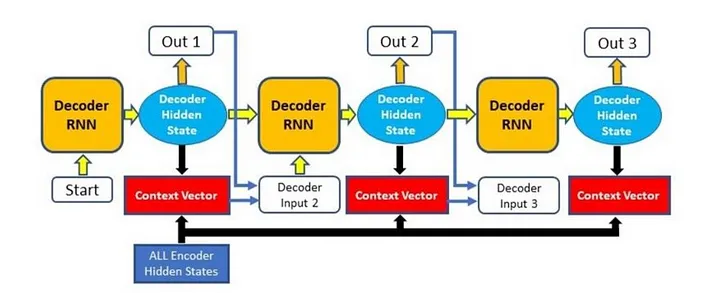

### Test implementation

In the following code snippet, we test the implemented decoder with attention using a minibatch of four sequences, each of which are seven time steps long.

If the `check_shape` test fails an error will be printed, otherwise nothing will happen :)

In [51]:
# test the implemented decoder with attention using a minibatch of
#four sequences, each of which are seven time steps long.

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

'''
check the shape of the tensor using the check_shape function,
which takes a tensor and expected shape, returns True if shape is similar,
False otherwise.
'''
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

### Hyperparameters & Data loading

Now that the encoder and decoder parts are ready we can proceed to training: specifying hyperparameters, instantiate an encoder and a decoder with attention, and train this model for machine translation.

<br>

---
> **Task 1.5** Set model hyperparameters.
---


In [52]:
# the below values were set after hyper parameters tuning as would be described in section 1.7

embed_size = 1024
num_hiddens = 128
num_layers = 3
dropout = 0.2
learning_rate = 0.001

batch_size = 4

We will use a predefined method `MTFraEng` from d2l which takes the batch_size and loads the English-French dataset. The implemented method
- Downloads a txt file and saves it in `./data/fra-eng/fra.txt`
- Preprocesses the setences: lower case, adds/removes spaces where needed.
- Tokenization, splits sentences by tab charachters and appens <eos> tokens for each setence. results in source-target pairs.
- Array building, builds arrays from the tokenized sentences, converting words to indices using vocabularies and padding/truncating sequences to a fixed length. It also constructs vocabularies if not provided.

The method parameters:
1. `batch_size`.
2. `num_steps` (default=9) - specifies the sequence length. Anything longer will be cut, shorter will be padded with "<pad\>".
3. `num_train` (default=512).
4. `num_eval` (default=128).

In [53]:
data = d2l.MTFraEng(batch_size=batch_size)

The `data` object contains the preprocessed data in the form of tensors. Each source-target setence is represeted using four tensors:

- Source Sequence: Represents the input source sequence. Each element in this array corresponds to a token in the source sequence.
- Target Sequence Input: Represents the input to the decoder (target sequence) during training. This sequence is left-shifted compared to the original target sequence. It excludes the <bos> token and includes the <eos> token.
- Source Sequence Length:
 Represents the lengths of the source sequences. Each element in this array indicates the length of the corresponding source sequence. It is often used to mask padding tokens during computation.
- Target Sequence Output: Represents the expected output from the decoder (target sequence) during training. This sequence is the same as the original target sequence without any modifications. It includes the <bos> token and excludes the <eos> token.

Lets take a look at a sample.

In [ ]:
# @title View data sample

arrays = data.arrays

# Select a sample from the arrays
sample_idx = 2 # @param {type:"integer"}
sample = {
    'source_sequence': arrays[0][sample_idx],  # Source sequence
    'target_sequence_input': arrays[1][sample_idx],  # Target sequence input
    'source_sequence_length': arrays[2][sample_idx],  # Source sequence length
    'target_sequence_output': arrays[3][sample_idx]  # Target sequence output
}

# Print the sample
print("Sample Source Sequence:", sample['source_sequence'])
print("Sample Target Sequence Input:", sample['target_sequence_input'])
print("Sample Source Sequence Length:", sample['source_sequence_length'])
print("Sample Target Sequence Output:", sample['target_sequence_output'])

Sample Source Sequence: tensor([135,   0,   3,   4,   4,   4,   4,   4,   4])
Sample Target Sequence Input: tensor([ 3, 55,  0,  4,  5,  5,  5,  5,  5])
Sample Source Sequence Length: tensor(3)
Sample Target Sequence Output: tensor([55,  0,  4,  5,  5,  5,  5,  5,  5])


Additionally we can view the resulting vocabulary size using:


In [54]:
print("Source voc size: ", len(data.src_vocab))
print("Target voc size: ", len(data.tgt_vocab))

Source voc size:  194
Target voc size:  214


In [79]:
#define source and target vocabulary size
#source is English, target is French
vocab_size_src=194
vocab_size_target=214

### Training

First, we will create instances of the encoder and decoder with the required parameters. Next, we will use a prebuilt `Seq2Seq` class and a `Trainer` from the d2l library. These will encapsulate both the encoder and decoder, allowing us to train the final model with the loaded data.

The Seq2Seq class, along with additional methods, enables us to create compelling visualizations during the training process. This is part of the class code.



```
class Seq2Seq(d2l.EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]
      
    ...
```



<br>



---
>**Task 1.6** Fill in the missing parameters in creation of encoder and decoder instances, and in the trainer instance.
---

Total training time: 367.0 seconds


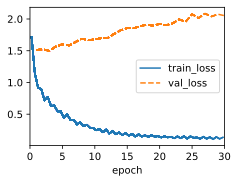

In [57]:
# train the model using a prebuilt trainer function in d2l
encoder = Seq2SeqEncoder(vocab_size_src, embed_size, num_hiddens, num_layers,dropout=dropout)
decoder = Seq2SeqAttentionDecoder(vocab_size_target, embed_size, num_hiddens, num_layers,dropout=dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)

#measure training time for comparison
start_time = time.time()
#setup trainer function
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=0.2, num_gpus=1) # we set 30 epochs becaue in most cases this is were we reached sufficient learning
trainer.fit(model, data) #train/fit the model with the loaded data
end_time = time.time()
#print training time
total_time = round((end_time - start_time),0)
print(f"Total training time: {total_time} seconds")

### Test a sample

After the model is trained, we use it to translate a few English sentences into French and compute their BLEU scores

In [58]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


### Visualize Attention

Let’s visualize the attention weights when translating the last English sentence.

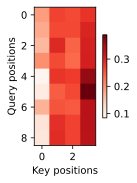

In [59]:
# predict on sample [-1] (last sample)
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)

attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')


---
> **Task 1.7** Discuss the resulting visualization, you can run it a few times to have a wider overview.

---



We've done hyper paramter tuning, the results below are sorted as an image matrix, meaning [0,0] is the top left image all the way to [2,2] on the bottom right corner

Starting from [0,0] the BLUE results were low, most sentences with 0. Then in image [1,0] with increased learning rate the loss went down but BLUE results still low

Our thought was that the dropout is too low and the network is stuck

After adjusting the dropout and iterating through different hidden layers and learning rates we came to a conclusion that a higher hidden layer value yeilded the best results, and defined 128 as our value

Next, as we thought we might be in an overfitting scenario, our method was to decrease embedding size but increase batch size in parallel (images [1,2] and [2,2]). **Still parameters in image [2,1] were chosen as the ones to proceed with**

We've also looked at the heatmap that shows how the attention was spread throughout the prediction process. Besides image [0,3] and [1,3] the prediction process uses mainly the end of the sentence to predict the query. The heatmap presents where the model's attention was while taking the query (input sequence) that starts in the zero position. A higher key means that the model reviewed a later part of the sentence, which was the case on almost all tests. Need to remember that when not using a random seed, each test reviewed a different batch/sequence, therefore results will not be replicated. On image [0,3] the attention was spread, starting from end of input sequence to start and back to end. Image [1,3] shows attention was on the beginning of the input sequence. We can only state that the end of sequence was used more frequently as an attention mechanism

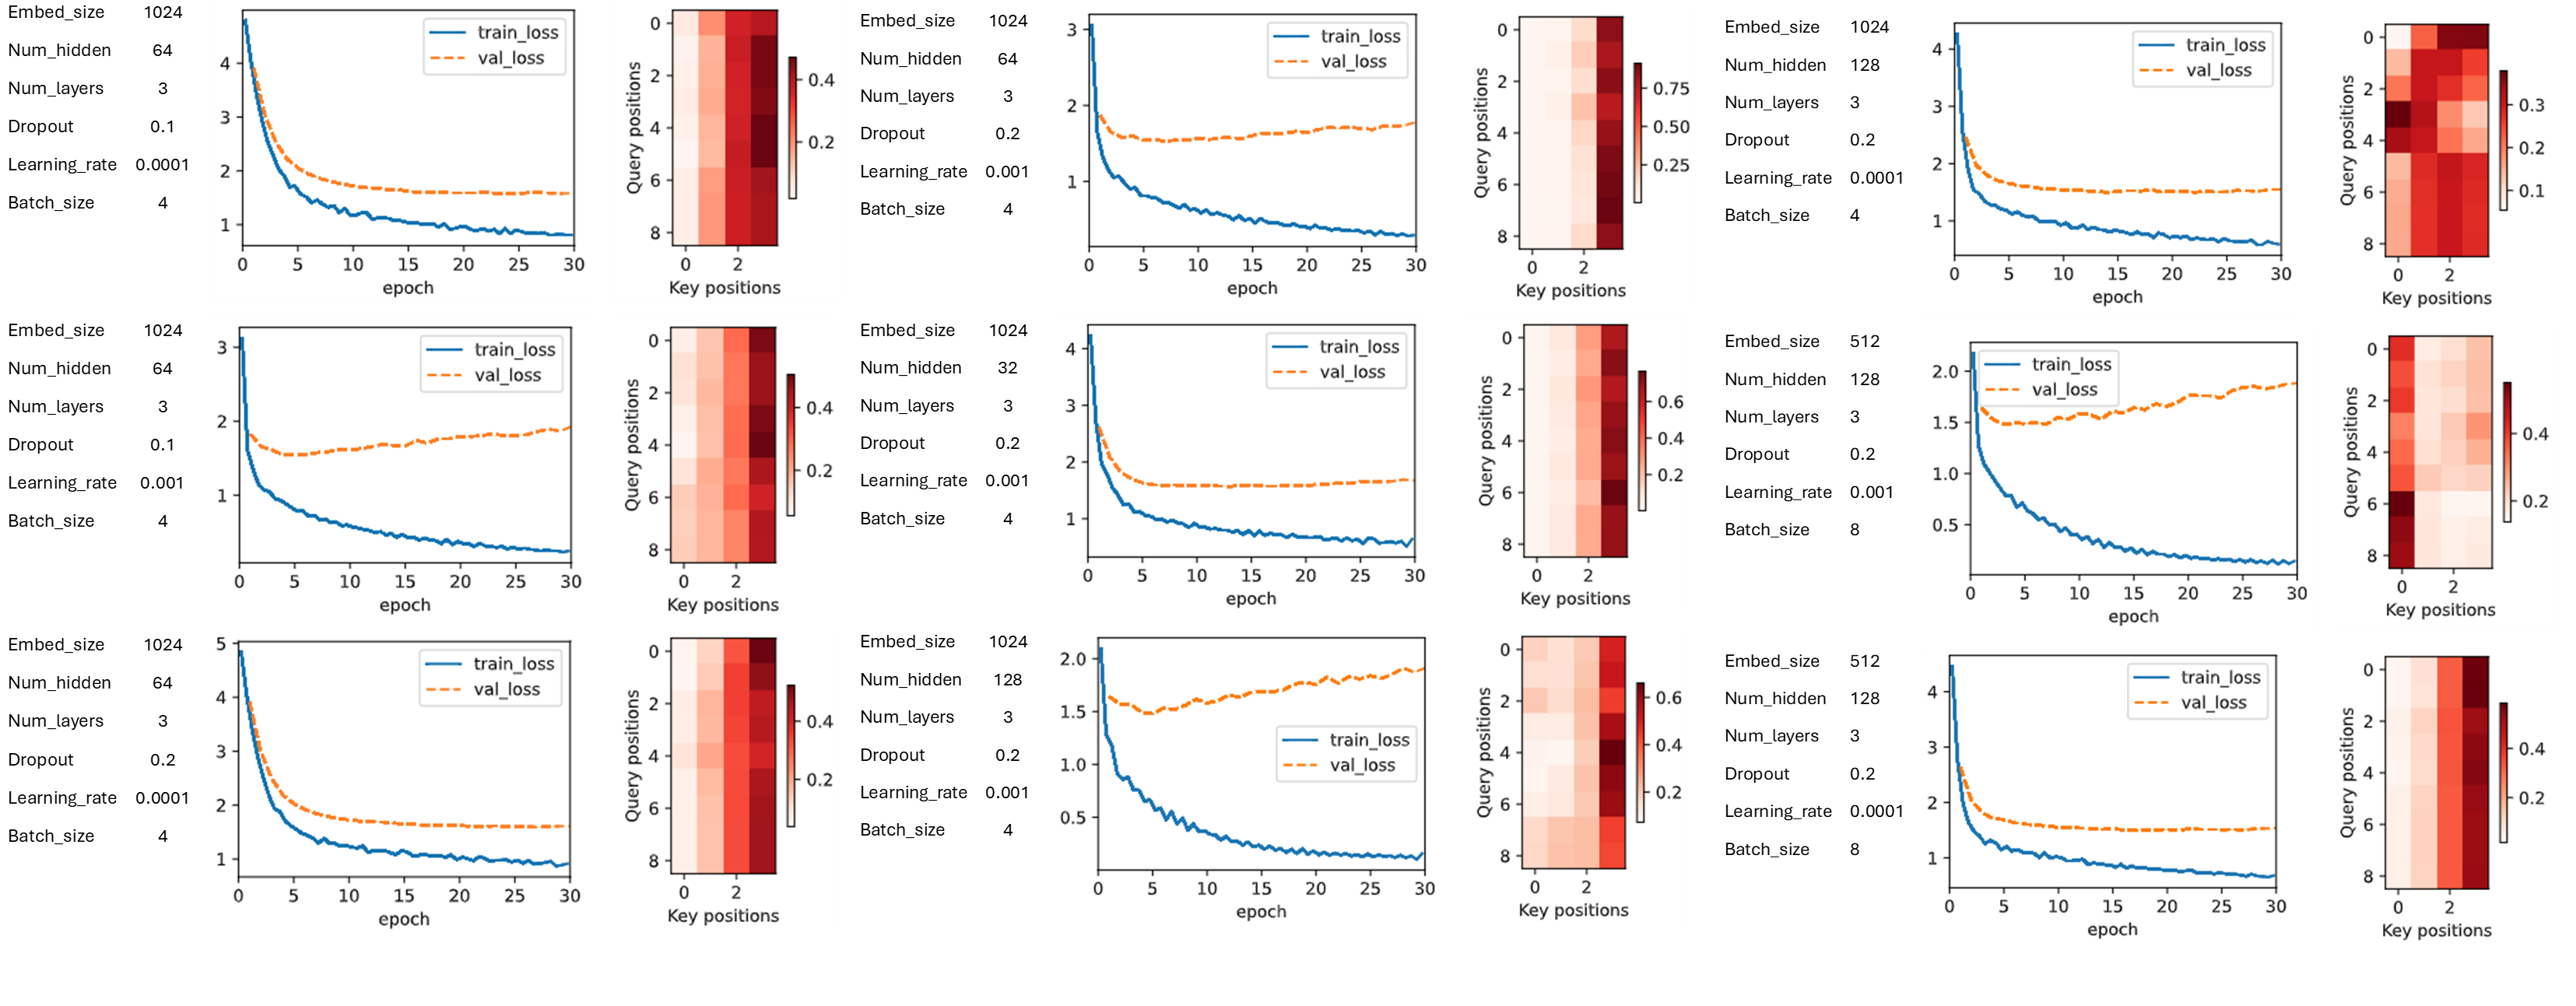

# Part 2

In the following part you need to experiment with different changes to the current model and discuss the outcomes. You can use any previosly implemented classes/methods and only write the changed classes here.


> **Task 2.1** Add additional layer/s to the current setup, how do the additional layers affect the training efficiency?

We were unsure about what the task meant, so we've perfromed two different actions

The first is to add two more layers of RNN

In [60]:
# parameters for section 2.1 - adding two more RNN layers
embed_size = 1024
num_hiddens = 128
num_layers = 5         #was previously 3 and added 2 more
dropout = 0.2
learning_rate = 0.001

batch_size = 4

Total training time: 491.0 seconds


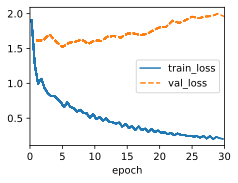

In [64]:
# running the same training as before
encoder = Seq2SeqEncoder(vocab_size_src, embed_size, num_hiddens, num_layers,dropout=dropout)
decoder = Seq2SeqAttentionDecoder(vocab_size_target, embed_size, num_hiddens, num_layers,dropout=dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)

#measure training time for comparison
start_time = time.time()
#setup trainer function
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=0.2, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data
end_time = time.time()
#print training time
total_time = round((end_time - start_time),0)
print(f"Total training time: {total_time} seconds")

In [65]:
# testing to compare
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['poursuis', '!'], bleu,0.000
i lost . => ['j’ai', 'perdu', '.'], bleu,0.687
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


After adding two additional RNN layers, training time increased from 360 to 490 seconds, while BLEU results decreased. This might be due to additional overfitting compared to an arcithecture with less layers. Deeper is not always better

Next, we've added an additional dense layer with reLU activation function.

We've printed the output tensor and found that the values range between 0 and a low decimal number, therefore reLU is a good fit

In [66]:
# define the decoder

class Seq2SeqAttentionDecoderWithMoreLayers(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens1,num_hiddens2, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoderWithMoreLayers, self).__init__()
    # initialize weights for seq2seq learning
    self.vocab_size=vocab_size
    self.embed_size=embed_size
    self.num_layers=num_layers

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.attention = MyAdditiveAttention(num_hiddens1,dropout)
    self.rnn=nn.GRU(num_hiddens+embed_size, num_hiddens1, num_layers, dropout=dropout)
    self.dense1=nn.Linear(num_hiddens1,num_hiddens2)
    # reLU activation
    self.relu1=nn.ReLU()
    # additional linear layer
    self.dense2=nn.Linear(num_hiddens2,vocab_size)
    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)

    outputs = self.dense1(torch.cat(outputs, dim=0))
    outputs=self.relu1(outputs)
    outputs=self.dense2(outputs)

    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs#V
    #print("outputs",outputs.size())
   # print('hidden_state',hidden_state.size())
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

In [67]:
# parameters for 2.1 with added dense layer

embed_size = 1024
num_hiddens1 = 128
num_hiddens2= 64
num_layers = 3
dropout = 0.2
learning_rate = 0.001

batch_size = 4

Total training time: 387.0 seconds


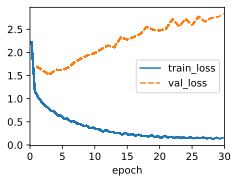

In [68]:
# train the model using a prebuilt trainer function in d2l
encoder = Seq2SeqEncoder(vocab_size_src, embed_size, num_hiddens, num_layers,dropout=dropout)
decoder = Seq2SeqAttentionDecoderWithMoreLayers(vocab_size_target, embed_size, num_hiddens1,num_hiddens2, num_layers,dropout=dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)

#measure training time for comparison
start_time = time.time()
#setup trainer function
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=0.2, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data
end_time = time.time()
#print training time
total_time = round((end_time - start_time),0)
print(f"Total training time: {total_time} seconds")

In [69]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Adding another linear layer increased traning time by about 20 seconds with no added value in BLUE score. From the training vs. validation loss we do see a higher validation loss which means more overfitting. The idea was that another layer might locate the features to the more important ones, but with our proposed change this wasn't the case

**Conclusion:** Adding layers did not imporove our model

> **Task 2.2** Replace GRU with LSTM in the experiment.

In [80]:
# define the encoder

class Seq2SeqEncoderLSTM(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
              dropout=0):
    super().__init__()
    self.vocab_size=vocab_size
    self.embed_size=embed_size
    self.num_hiddens=num_hiddens
    self.num_layers=num_layers

    self.embedding = nn.Embedding(vocab_size, embed_size)

    # replace to LSTM
    self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
    # initialize weights for seq2seq learning
    self.apply(d2l.init_seq2seq)

  def forward(self, X, *args):
    X=X.permute(1, 0)
    embedded=self.embedding(X)
    results, (hidden_state, cell_state) = self.rnn(embedded)
    return results, (hidden_state, cell_state)

In [88]:
# define the decoder

class Seq2SeqAttentionDecoderLSTM(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoderLSTM, self).__init__()
    # initialize weights for seq2seq learning
    self.vocab_size=vocab_size
    self.embed_size=embed_size
    self.num_hiddens=num_hiddens
    self.num_layers=num_layers

    self.embedding = nn.Embedding(vocab_size, embed_size)

    self.attention = MyAdditiveAttention(num_hiddens,dropout)
    # replace to LSTM
    self.rnn=nn.LSTM(num_hiddens+embed_size, num_hiddens, num_layers, dropout=dropout)
    self.dense=nn.Linear(num_hiddens,vocab_size)
    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    enc_outputs, (hidden_state, cell_state), enc_valid_lens = state
    # if isinstance(hidden_state, tuple):
    #     hidden_state, cell_state = hidden_state
    # else:
    #   cell_state=hidden_state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      # modified from GRU to LSTM which needs a tuple of both the hidden and the cell states
      out, (hidden_state, cell_state) = self.rnn(x.permute(1, 0, 2) , (hidden_state, cell_state))
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), (enc_outputs, (hidden_state, cell_state), enc_valid_lens)

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    outputs, (hidden_state, cell_state) = enc_outputs
    return (outputs.permute(1, 0, 2), (hidden_state, cell_state), enc_valid_lens)

In [82]:
# parameters for section 2.2 using LSTM instead of GRU

embed_size = 1024
num_hiddens = 128
num_layers = 3
dropout = 0.2
learning_rate = 0.001

batch_size = 4

Total training time: 508.0 seconds


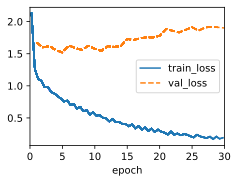

In [91]:
# train the model using a prebuilt trainer function in d2l
encoder = Seq2SeqEncoderLSTM(vocab_size_src, embed_size, num_hiddens, num_layers,dropout=dropout)
decoder = Seq2SeqAttentionDecoderLSTM(vocab_size_target, embed_size, num_hiddens, num_layers,dropout=dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)

#measure training time for comparison
start_time = time.time()
#setup trainer function
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=0.2, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data
end_time = time.time()
#print training time
total_time = round((end_time - start_time),0)
print(f"Total training time: {total_time} seconds")

In [92]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ['je', "l'ai", 'fait', '.'], bleu,0.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Running time increased drastically with lower BLUE results. The added training time is expected since there are additional calculations done (cell and hidden states). The hyper parameters tuning were made to match the best output from GRU, that's why we believe that with different hyper parameters and/or additional epochs the LSTM results could increase (it seems that training loss could be lowered with additional training)

Conclusion: On same hyper parameters comparison between GRU and LSTM, there is no advantage for LSTM over GRU

> **Task 2.3** Modify the experiment to replace the additive attention scoring function with the scaled dot-product. How does it influence the training efficiency?

The dot product code was initially consturcted with ChatGPT 4, and modified to fit the model better

The chat could be found [here](https://chat.openai.com/share/b54889cd-e27c-4058-a660-ff2c67338d66)

In [75]:
# dot product class

class ScaledDotProductAttention(torch.nn.Module):
  def __init__(self):
    super(ScaledDotProductAttention, self).__init__()
    self._attention_weights = None

  def forward(self, q, k, v, mask=None):
    #replacing the calculation to dot product based on the method presented in Tirgul 6
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)

    #same process as in myAdditiveAttention
    self._attention_weights = masked_softmax(attn_logits, mask)
    out = torch.bmm(self._attention_weights, v)
    return out

  @property
  def attention_weights(self):
    return self._attention_weights

In [76]:
# define the decoder with dot prodct

class Seq2SeqAttentionDecoderDotProduct(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoderDotProduct, self).__init__()
    # initialize weights for seq2seq learning
    self.vocab_size=vocab_size
    self.embed_size=embed_size
    self.num_hiddens=num_hiddens
    self.num_layers=num_layers

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout=nn.Dropout(dropout)
    self.attention = ScaledDotProductAttention()
    self.rnn=nn.GRU(num_hiddens+embed_size, num_hiddens, num_layers, dropout=dropout)
    self.dense=nn.Linear(num_hiddens,vocab_size)
    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs#V
    #print("outputs",outputs.size())
   # print('hidden_state',hidden_state.size())
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

Total training time: 334.0 seconds


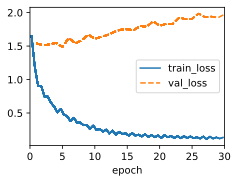

In [77]:
# train the model using a prebuilt trainer function in d2l
encoder = Seq2SeqEncoder(vocab_size_src, embed_size, num_hiddens, num_layers,dropout=dropout)
decoder = Seq2SeqAttentionDecoderDotProduct(vocab_size_target, embed_size, num_hiddens, num_layers,dropout=dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)

#measure training time for comparison
start_time = time.time()
#setup trainer function
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=0.2, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data
end_time = time.time()
#print training time
total_time = round((end_time - start_time),0)
print(f"Total training time: {total_time} seconds")

In [78]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Dot product ran a bit faster, with small compromise on results. We did not see a need to add a dropout layer as myAdditiveAttention had because we did not reach overfitting

Conclusion: Dot product performed faster with almost the same accuracy, which we feel is acceptable for this architecture and task, but not enough to replace myAdditiveAttention

**Final Analysis**

Finidngs:


*   On a small dataset there are no major differences between attention types and RNN types.
*   Due to the small dataset it's very easy to reach overfitting and measures such as dropouts, smaller embedding sizes and less layers are good practice.

Challenges:


*   Handling the dimensions throughout the code was challenging. There's a need for many permutations to prepare the data for each layer to handle. This makes it very a very complex task to code with a lot of room for error.
*   As opposed to convolution, the attention mechanism and hidden layer data that is passed between iterations is less trivial to understand and to explain. So when just looking at results you don't always know if the code is off or just hyper parameter tuning is needed. The process is less visual.

Future Improvements:


*   Hyper parameters tuning for LSTM as well to verify it it could perform better.
*   Test of a larger dataset and/or another language to expand the differences in BLUE and training time. For starters it might be easier to start with attional test inputs (mroe than four).
*   Try replacing the attention method to self attention and compare.






# Helper Functions

Attached are two functions that were used from the `d2l` library.
They are provided for anyone that seeks further clarification of their preformance.

In [ ]:
class MTFraEng(d2l.DataModule):
  """The English-French dataset"""
  def _download(self):
    d2l.extract(d2l.download(
      d2l.DATA_URL+'fra-eng.zip', self.root,
      '94646ad1522d915e7b0f9296181140edcf86a4f5'))
    with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
      return f.read()

  def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
          for i, char in enumerate(text.lower())]
    return ''.join(out)

  def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
      if max_examples and i > max_examples: break
      parts = line.split('\t')
      if len(parts) == 2:
        # Skip empty tokens
        src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
        tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

  def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
      self._download())

  def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
      pad_or_trim = lambda seq, t: (
        seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
      sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
      if is_tgt:
        sentences = [['<bos>'] + s for s in sentences]
      if vocab is None:
        vocab = d2l.Vocab(sentences, min_freq=2)
      array = d2l.tensor([vocab[s] for s in sentences])
      valid_len = d2l.reduce_sum(
        d2l.astype(array != vocab['<pad>'], d2l.int32), 1)
      return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab)

  def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

  def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
      src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
      raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

class Trainer(d2l.HyperParameters):
  """The base class for training models with data."""
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'

  def prepare_data(self, data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader)
                            if self.val_dataloader is not None else 0)

  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    self.model = model

  def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()

  def fit_epoch(self):
    raise NotImplementedError

  def prepare_batch(self, batch):
    return batch

  def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
      loss = self.model.training_step(self.prepare_batch(batch))
      self.optim.zero_grad()
      with torch.no_grad():
        loss.backward()
        if self.gradient_clip_val > 0:  # To be discussed later
          self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step()
      self.train_batch_idx += 1
    if self.val_dataloader is None:
      return
    self.model.eval()
    for batch in self.val_dataloader:
      with torch.no_grad():
        self.model.validation_step(self.prepare_batch(batch))
      self.val_batch_idx += 1

  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

  def prepare_batch(self, batch):
    if self.gpus:
      batch = [d2l.to(a, self.gpus[0]) for a in batch]
    return batch

  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
      model.to(self.gpus[0])
    self.model = model

  def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
      for param in params:
        param.grad[:] *= grad_clip_val / norm
